### Demonstation of wavefront (equal time) visualization in $n(x,y)$ environment

Uses the arc-length parametrized eikonal ray equation and post-processing.

In [1]:
import numpy as np
import scipy.integrate as scintegr
import scipy.interpolate as scinterp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
def action_ode(A, t, refrfunc = None):
    assert A.size == 6 # ray state A = [s, x, y, px, py, a]
    n, dnx, dny = refrfunc(A[1], A[2])
    return np.array([1.0, A[3] / n, A[4] / n, dnx, dny, n])

ode_rtol = 1.0e-8
ode_atol = 1.0e-8

In [3]:
def refr_glassplate(x, y, nair = 1.00, nglass = 1.50, W = 1.00, tW = 0.10):
    z1 = np.exp(- (x + W / 2) / tW)
    z2 = np.exp(- (x - W / 2) / tW)
    dz1dx = -1 * z1 / tW
    dz2dx = -1 * z2 / tW
    s1 = 1 / (1 + z1)
    s2 = 1 / (1 + z2)
    value = nair + (nglass - nair) * (s1 - s2)
    gradx = (nglass - nair) * ( (dz1dx) * -1 / (1 + z1) ** 2 + (dz2dx) * 1 / (1 + z2) ** 2)
    grady = 0.0 * z1
    return value, gradx, grady

In [4]:
xvec = np.linspace(-2, 2, 10001)
n, nx, ny = refr_glassplate(xvec, 0.0 * xvec)

n_check = n[0] + np.hstack([0.0, scintegr.cumtrapz(nx, xvec)])
err_check = np.max(np.abs(n - n_check)) 
print(err_check)
assert err_check < 1e-4

#plt.plot(xvec, n)
#plt.plot(xvec, n - n_check)
#plt.show()

6.426317811225601e-08


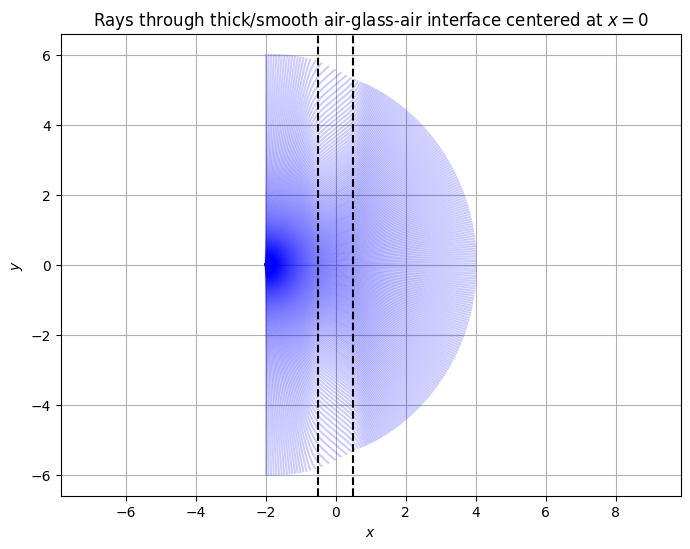

In [5]:
def odefunc(A, t):
    return action_ode(A, t, refrfunc = refr_glassplate)

x0 = -2.0
y0 = 0.0
n0, _, _ = refr_glassplate(x0, y0)
svec = np.linspace(0.0, 6.0, 1001)
nrays = 250

Rays = []

for deg in np.linspace(-90, 90, nrays):
    phi0 = deg * np.pi / 180.0
    A0 = np.array([0.0, x0, y0, n0 * np.cos(phi0), n0 * np.sin(phi0), 0.0])
    sol = scintegr.odeint(odefunc, A0, svec, 
                          full_output = 1, atol = ode_atol, rtol = ode_rtol,
                          hmax = 0.002)
    A = sol[0]
    assert A.shape[0] == svec.size and A.shape[1] == A0.size 
    assert np.isclose(A[-1, 0], svec[-1])
    plt.plot(A[:, 1], A[:, 2], c = 'b', alpha = 0.20)
    Rays.append(A) # save rays for post-processing

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.axvline(x = -0.5, c = 'k', linestyle = '--')
plt.axvline(x = +0.5, c = 'k', linestyle = '--')
plt.title('Rays through thick/smooth air-glass-air interface centered at $x=0$')
plt.show()

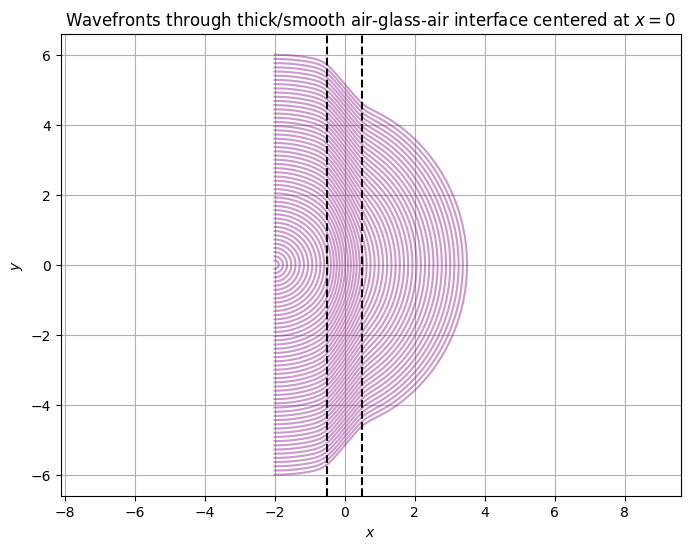

In [6]:
assert len(Rays) == nrays
endtimes = np.array([r[-1, -1] for r in Rays])
nfronts = 50
avec = np.linspace(0.0, np.min(endtimes), nfronts + 1)[1:]
assert len(avec) == nfronts

for k in range(nfronts):
    # record the equal-time points on each ray in the ray bundle
    xy = np.zeros((nrays, 2))
    ak = avec[k]
    q = 0
    for r in Rays:
        xrk = scinterp.interp1d(r[:, 5], r[:, 1])(ak)
        yrk = scinterp.interp1d(r[:, 5], r[:, 2])(ak)
        xy[q, :] = [xrk, yrk]
        q += 1
    plt.plot(xy[:, 0], xy[:, 1], alpha = 0.40, c = 'purple')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.axvline(x = -0.5, c = 'k', linestyle = '--')
plt.axvline(x = +0.5, c = 'k', linestyle = '--')
plt.title('Wavefronts through thick/smooth air-glass-air interface centered at $x=0$')
plt.show()